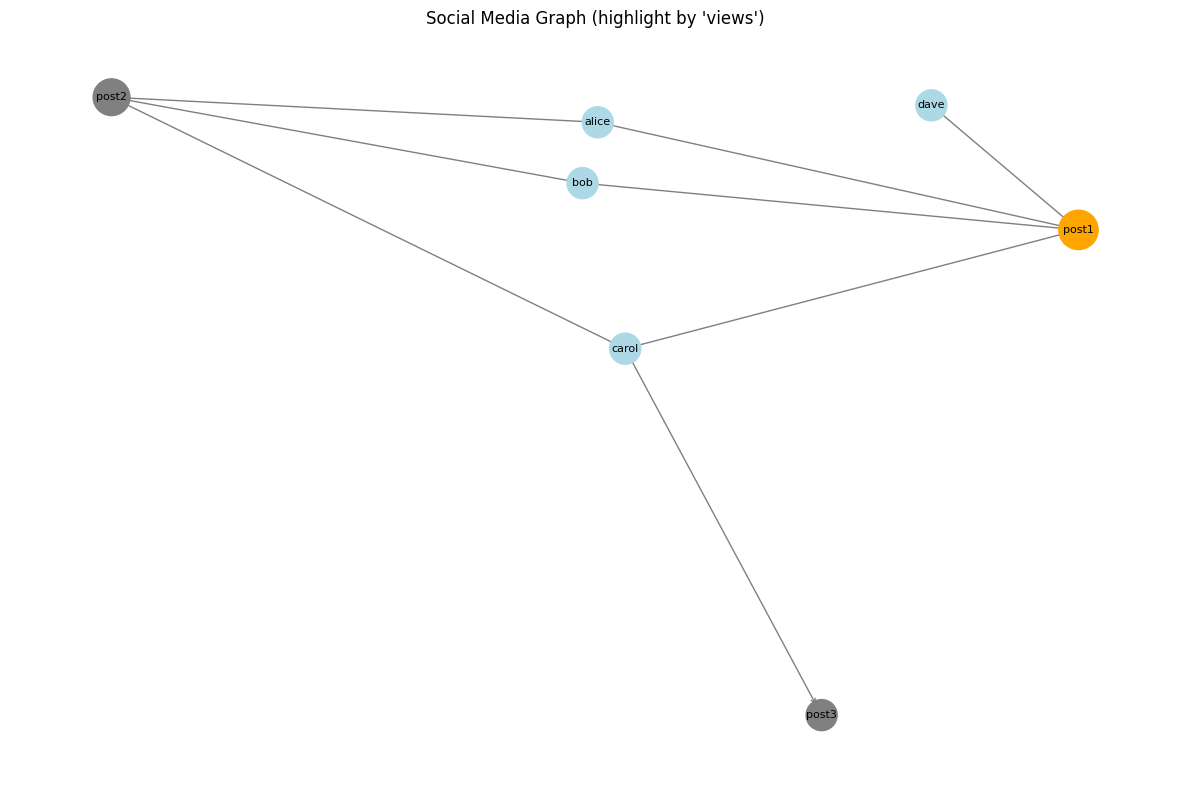

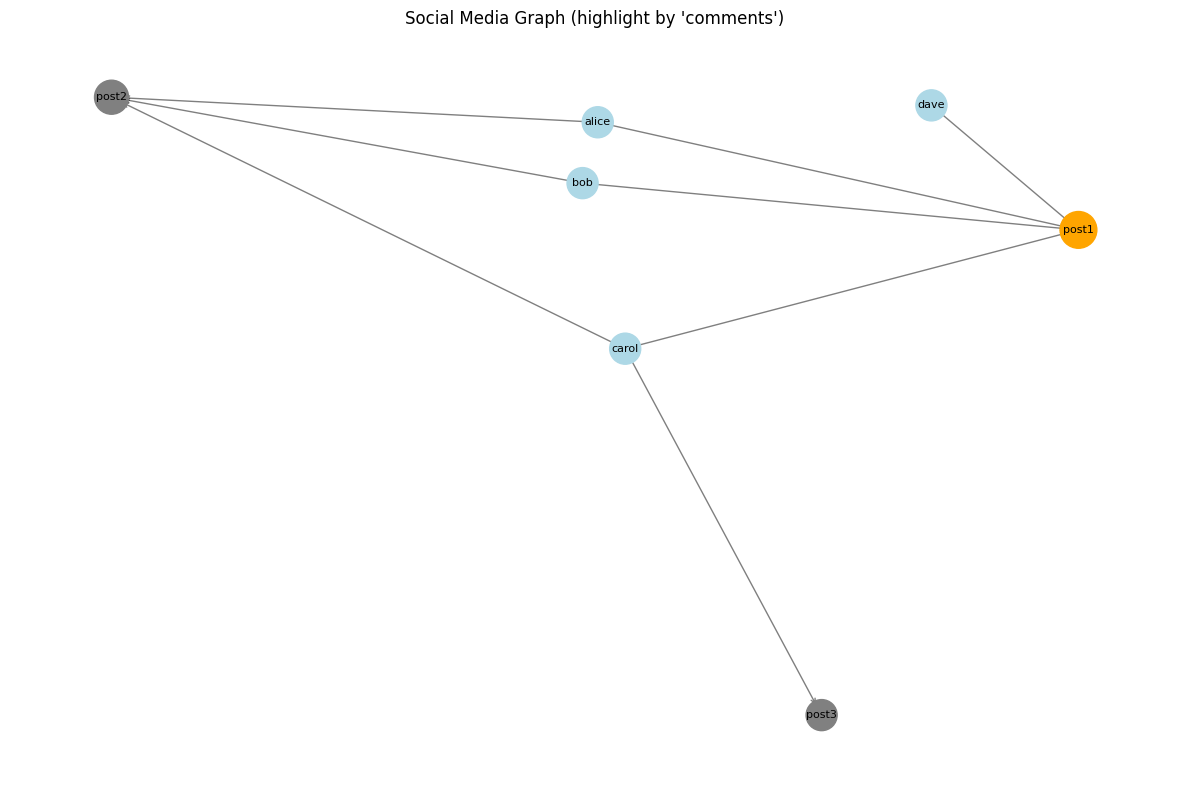

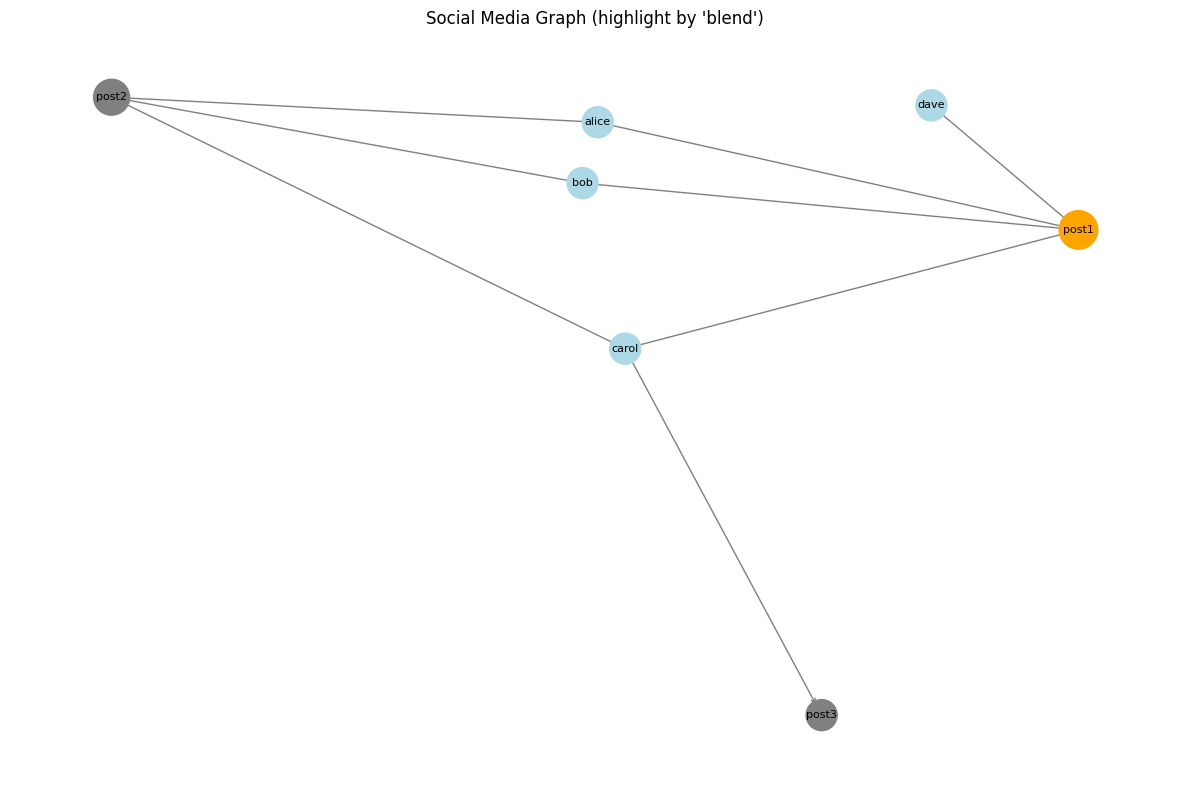

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_social_media_graph(data, importance='blend', blend_weights=(0.5, 0.5),
                            user_color='lightblue', post_color='gray', highlight_color='orange',
                            user_size=500, base_post_size=500, size_scale=100,
                            figsize=(12, 8), seed=42):
    """
    Plots a bipartite social media graph with users and posts as nodes.
    Edges represent authorship or viewing.
    Important posts are highlighted by color and size.

    Parameters:
    - data: dict with keys:
        'users': set or list of usernames
        'posts': dict mapping post_id to dict {
            'author': username,
            'views': list of usernames who viewed,
            'comments': list of comment dicts (each has 'user', 'content', 'timestamp')
        }
    - importance: 'views', 'comments', or 'blend'
    - blend_weights: tuple (w_views, w_comments) used if importance='blend'
    - user_color: node color for users
    - post_color: default node color for posts
    - highlight_color: node color for important posts
    - user_size: fixed node size for users
    - base_post_size: minimum node size for posts
    - size_scale: multiplier for importance score to node size
    - figsize: size of matplotlib figure
    - seed: random seed for layout reproducibility
    """

    g = nx.DiGraph()

    # Add user nodes
    for u in data['users']:
        g.add_node(u, type='user')

    # Add post nodes and edges, and compute importance scores
    post_scores = {}
    for pid, pinfo in data['posts'].items():
        g.add_node(pid, type='post')
        g.add_edge(pinfo['author'], pid, relation='authored')
        for viewer in pinfo.get('views', []):
            g.add_edge(viewer, pid, relation='viewed')

        n_views = len(pinfo.get('views', []))
        n_comments = len(pinfo.get('comments', []))
        if importance == 'views':
            score = n_views
        elif importance == 'comments':
            score = n_comments
        else:  # blend
            wv, wc = blend_weights
            score = wv * n_views + wc * n_comments
        post_scores[pid] = score

    # Highlight threshold = top 20%
    if post_scores:
        sorted_scores = sorted(post_scores.values(), reverse=True)
        idx = max(1, int(0.2 * len(sorted_scores))) - 1
        threshold = sorted_scores[idx]
    else:
        threshold = 0

    # Build styling lists
    node_colors, node_sizes = [], []
    for node, attrs in g.nodes(data=True):
        if attrs['type'] == 'user':
            node_colors.append(user_color)
            node_sizes.append(user_size)
        else:
            score = post_scores.get(node, 0)
            node_sizes.append(base_post_size + size_scale * score)
            node_colors.append(highlight_color if score >= threshold else post_color)

    # Layout and draw
    pos = nx.spring_layout(g, seed=seed, k=1.2, iterations=100)
    plt.figure(figsize=figsize)
    nx.draw_networkx_edges(g, pos, arrowstyle='->', arrowsize=8, alpha=0.5)
    nx.draw_networkx_nodes(g, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_labels(g, pos, font_size=8)
    plt.title(f"Social Media Graph (highlight by '{importance}')")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# ─── Example Usage ─────────────────────────────────────────────────────────────

if __name__ == "__main__":
    sample_data = {
        'users': {'alice', 'bob', 'carol', 'dave'},
        'posts': {
            'post1': {
                'author': 'alice',
                'views': ['bob', 'carol', 'dave'],
                'comments': [
                    {'user': 'bob',   'content': "Nice post!",       'timestamp': "2025-07-20T10:00"},
                    {'user': 'carol', 'content': "I agree with Bob.", 'timestamp': "2025-07-20T10:05"}
                ]
            },
            'post2': {
                'author': 'bob',
                'views': ['alice', 'carol'],
                'comments': [
                    {'user': 'alice', 'content': "Interesting...", 'timestamp': "2025-07-21T11:00"}
                ]
            },
            'post3': {
                'author': 'carol',
                'views': [],
                'comments': []
            }
        }
    }

    # Render three variants:
    plot_social_media_graph(sample_data, importance='views')
    plot_social_media_graph(sample_data, importance='comments')
    plot_social_media_graph(sample_data, importance='blend', blend_weights=(0.7, 0.3))
